<a href="https://colab.research.google.com/github/mantoan-thi/Wire-harness-analysis/blob/main/Teste_Inspe%C3%A7%C3%A3o_por_Camera_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA PARA INSPEÇÃO DE CHICOTES

## Importação das bibliotecas e base de dados

In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
xray_directory = '/content/drive/My Drive/train'

In [82]:
os.listdir(xray_directory)

['1', '0']

In [83]:
image_generator = ImageDataGenerator(rescale=1./255)

In [84]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 1000 images belonging to 2 classes.


In [85]:
133 * 4

532

In [86]:
532 / 40

13.3

In [87]:
train_images, train_labels = next(train_generator)

In [88]:
train_images.shape

(40, 256, 256, 3)

In [89]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [90]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Normal', 1: 'Defeito'}

## Visualização dos dados

In [91]:
np.arange(0, 100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [92]:
np.argmax(train_labels[0])

1

In [93]:
labels_names[1]

'Defeito'

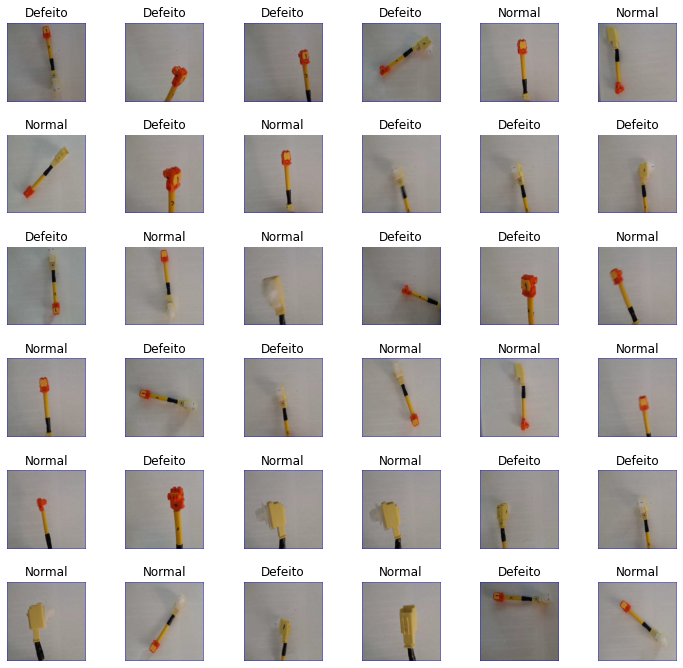

In [94]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

In [95]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

In [96]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [97]:
len(base_model.layers)

175

In [98]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## Construção e treinamento do modelo de deep learning

In [99]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [100]:
model = Model(inputs = base_model.input, outputs = head_model)

In [103]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [104]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [105]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 1000 images belonging to 2 classes.


In [106]:
history = model.fit(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.9360

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


250/250 [==============================] - 346s 1s/step - loss: 0.2676 - accuracy: 0.9360
Epoch 2/25
250/250 [==============================] - 63s 252ms/step - loss: 0.0408 - accuracy: 0.9890
Epoch 3/25
250/250 [==============================] - 63s 253ms/step - loss: 0.0400 - accuracy: 0.9980
Epoch 4/25
250/250 [==============================] - 64s 254ms/step - loss: 6.8886e-05 - accuracy: 1.0000
Epoch 5/25
250/250 [==============================] - 64s 254ms/step - loss: 0.0176 - accuracy: 0.9990
Epoch 6/25
250/250 [==============================] - 63s 254ms/step - loss: 0.0180 - accuracy: 0.9990
Epoch 7/25
250/250 [==============================] - 63s 253ms/step - loss: 1.2017e-05 - accuracy: 1.0000
Epoch 8/25
250/250 [==============================] - 63s 254ms/step - loss: 4.4107e-09 - accuracy: 1.0000
Epoch 9/25
250/250 [==============================] - 63s 254ms/step - loss: 1.8358e-08 - accuracy: 1.0000
Epoch 10/25
250/250 [==============================] - 64s 255ms/step 

## Avaliação da rede neural

In [107]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

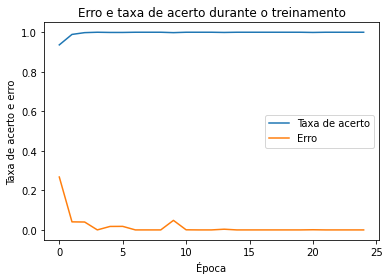

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [109]:
test_directory = '/content/drive/My Drive/train'

In [110]:
os.listdir(test_directory)

['1', '0']

In [111]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 1000 images belonging to 2 classes.


In [112]:
evaluate = model.evaluate(test_generator)

25/25 [==============================] - 10s 324ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [113]:
evaluate

[0.0, 1.0]

In [114]:
len(os.listdir(test_directory))

2

In [115]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [116]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [117]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [118]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [119]:
accuracy_score(original, prediction)

1.0

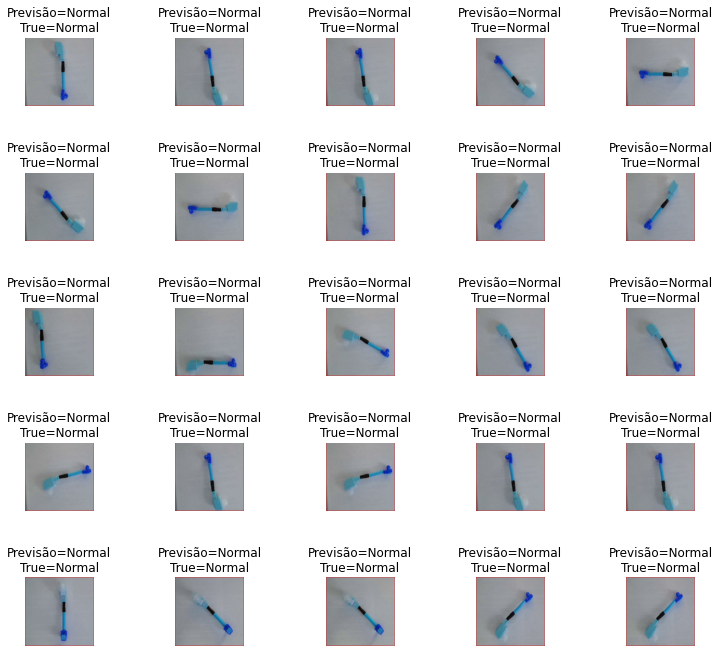

In [120]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [121]:
labels_names

{0: 'Normal', 1: 'Defeito'}

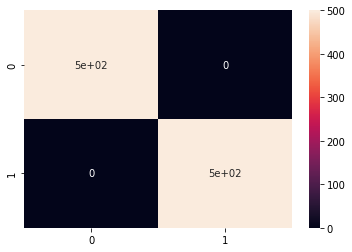

In [122]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [123]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Classificação de somente uma imagem

In [124]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [125]:
model_loaded.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [126]:
4 * 4 * 2048

32768

In [178]:
img = cv2.imread('/content/drive/My Drive/train/1/0046-Imagem.jpg')

In [179]:
img, img.shape

(array([[[202,   8,   1],
         [183,  13,   9],
         [140,  12,  13],
         ...,
         [143,  17,  13],
         [179,   9,   5],
         [201,  11,   6]],
 
        [[184,  11,   8],
         [255, 110, 109],
         [224, 121, 124],
         ...,
         [249, 146, 144],
         [255, 141, 139],
         [186,  16,  14]],
 
        [[140,  10,  11],
         [226, 121, 124],
         [174, 123, 127],
         ...,
         [203, 150, 153],
         [254, 151, 154],
         [149,  20,  23]],
 
        ...,
 
        [[140,  10,  11],
         [211, 107, 108],
         [158, 104, 109],
         ...,
         [191, 141, 145],
         [241, 140, 142],
         [151,  24,  25]],
 
        [[182,  11,   9],
         [247,  97,  96],
         [210, 105, 108],
         ...,
         [240, 140, 140],
         [255, 136, 134],
         [186,  20,  15]],
 
        [[201,   8,   4],
         [181,  10,   8],
         [143,  13,  14],
         ...,
         [140,  14,  13],
  

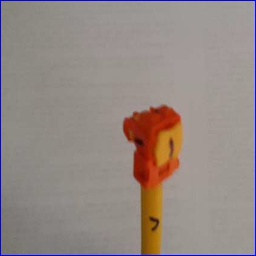

In [180]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

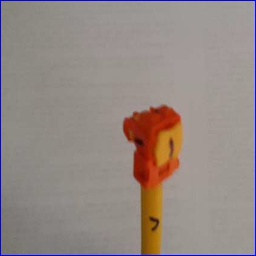

In [181]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [182]:
img = img / 255
img

array([[[0.79215686, 0.03137255, 0.00392157],
        [0.71764706, 0.05098039, 0.03529412],
        [0.54901961, 0.04705882, 0.05098039],
        ...,
        [0.56078431, 0.06666667, 0.05098039],
        [0.70196078, 0.03529412, 0.01960784],
        [0.78823529, 0.04313725, 0.02352941]],

       [[0.72156863, 0.04313725, 0.03137255],
        [1.        , 0.43137255, 0.42745098],
        [0.87843137, 0.4745098 , 0.48627451],
        ...,
        [0.97647059, 0.57254902, 0.56470588],
        [1.        , 0.55294118, 0.54509804],
        [0.72941176, 0.0627451 , 0.05490196]],

       [[0.54901961, 0.03921569, 0.04313725],
        [0.88627451, 0.4745098 , 0.48627451],
        [0.68235294, 0.48235294, 0.49803922],
        ...,
        [0.79607843, 0.58823529, 0.6       ],
        [0.99607843, 0.59215686, 0.60392157],
        [0.58431373, 0.07843137, 0.09019608]],

       ...,

       [[0.54901961, 0.03921569, 0.04313725],
        [0.82745098, 0.41960784, 0.42352941],
        [0.61960784, 0

In [183]:
img.shape

(256, 256, 3)

In [185]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [186]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.1796678e-09, 1.0000000e+00]], dtype=float32)>

In [187]:
predict2 = np.argmax(predict)
predict2

1

In [188]:
labels_names[predict2], predict[0][predict2]

('Defeito', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)